# Importing Libraries

### Libraries

In [3]:
import pandas as pd
import numpy as np
import warnings

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv

from IPython.display            import Markdown

from sklearn.preprocessing      import LabelEncoder
from sklearn.ensemble           import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model       import LogisticRegression
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.model_selection    import train_test_split, KFold
from sklearn.metrics            import roc_auc_score, accuracy_score, roc_curve
from sklearn.feature_selection  import SelectKBest, chi2
from skopt                      import dummy_minimize
from sklearn                    import metrics

### Auxiliary Functions and Configurations

In [4]:
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('ggplot')

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

def func_LabelEncoder(df):
    return LabelEncoder().fit_transform(df)

def LazzyLabelEncoder(df, text=True):
    text_LazzyLabelEncoder = ''
    dicio_LazzyLabelEncoder = {}
    for i, j in enumerate(df.unique()):
        text_LazzyLabelEncoder += f'{i} - {j}\n '
        dicio_LazzyLabelEncoder[j] = i
    return text_LazzyLabelEncoder[:-2] if text==True else dicio_LazzyLabelEncoder

def df_informations(df):
    df_info = pd.DataFrame({'Not Null': df.notnull().count(),
                'Null': df.isnull().sum(),
                'Perce Null': df.isnull().sum() / len(df),
                'Dtype': df.dtypes,
                })

    df_dtype = pd.DataFrame(df_info['Dtype'].value_counts())
    df_dtype['Perce'] = round(df_dtype['Dtype'] / df_dtype['Dtype'].sum(), 2)

    text = f'Dataset has {df.shape[0]} rows and {df.shape[1]} columns. From these, we have:'

    df_info = df_info.style.background_gradient(cmap='jet', subset=['Perce Null']).format({'Perce Null': '{:.2%}'})
    df_dtype = df_dtype.style.background_gradient(cmap='YlGn', subset=['Perce']).format({'Perce': '{:.2%}'})

    display(Markdown("<H3 style='text-align:left;float:lfet;'>Information about the Dataset"))
    display(Markdown(f'<H5> {text}'))
    display(df_info)
    display(Markdown("<H3 style='text-align:left;float:lfet;'>About Dtypes we have:"))
    display(df_dtype)

# Data Understanding

## Collect  Initial Data

In [5]:
df = pd.read_csv('bank_customer_churn_prediction.csv')
df_sv = df.copy()
df

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,15569892,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,15682355,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


## Describe Data

The dataset collected from Kaggle (https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset?resource=download).

- customer_id, <font color='red'>unused variable</font>.
- credit_score, <font color='chartreuse'>used as input</font>.
- country, <font color='chartreuse'>used as input</font>.
- gender, <font color='chartreuse'>used as input</font>.
- age, <font color='chartreuse'>used as input</font>.
- tenure, <font color='chartreuse'>used as input</font>.
- balance, <font color='chartreuse'>used as input</font>.
- products_number, <font color='chartreuse'>used as input</font>.
- credit_card, <font color='chartreuse'>used as input</font>.
- active_member, <font color='chartreuse'>used as input</font>.
- estimated_salary, <font color='chartreuse'>used as input</font>.
- churn, <font color='orange'>used as the target</font>. 1 if the client has left the bank during some period or 0 if he/she has not.

Dropping the customer_id column

In [6]:
df = df.drop(['customer_id'], axis=1)

Data Information

In [7]:
df_informations(df)

<H3 style='text-align:left;float:lfet;'>Information about the Dataset

<H5> Dataset has 10000 rows and 11 columns. From these, we have:

,Not Null,Null,Perce Null,Dtype
credit_score,10000,0,0.00%,int64
country,10000,0,0.00%,object
gender,10000,0,0.00%,object
age,10000,0,0.00%,int64
tenure,10000,0,0.00%,int64
balance,10000,0,0.00%,float64
products_number,10000,0,0.00%,int64
credit_card,10000,0,0.00%,int64
active_member,10000,0,0.00%,int64
estimated_salary,10000,0,0.00%,float64


<H3 style='text-align:left;float:lfet;'>About Dtypes we have:

,Dtype,Perce
int64,7,64.00%
object,2,18.00%
float64,2,18.00%


In [8]:
df.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
credit_score,10000.00,650.53,96.65,350.00,432.00,584.00,652.00,718.00,850.00,850.00
age,10000.00,38.92,10.49,18.00,21.00,32.00,37.00,44.00,72.00,92.00
tenure,10000.00,5.01,2.89,0.00,0.00,3.00,5.00,7.00,10.00,10.00
balance,10000.00,76485.89,62397.41,0.00,0.00,0.00,97198.54,127644.24,185967.99,250898.09
products_number,10000.00,1.53,0.58,1.00,1.00,1.00,1.00,2.00,3.00,4.00
credit_card,10000.00,0.71,0.46,0.00,0.00,0.00,1.00,1.00,1.00,1.00
active_member,10000.00,0.52,0.50,0.00,0.00,0.00,1.00,1.00,1.00,1.00
estimated_salary,10000.00,100090.24,57510.49,11.58,1842.83,51002.11,100193.91,149388.25,198069.73,199992.48
churn,10000.00,0.20,0.40,0.00,0.00,0.00,0.00,0.00,1.00,1.00


## Explore Data

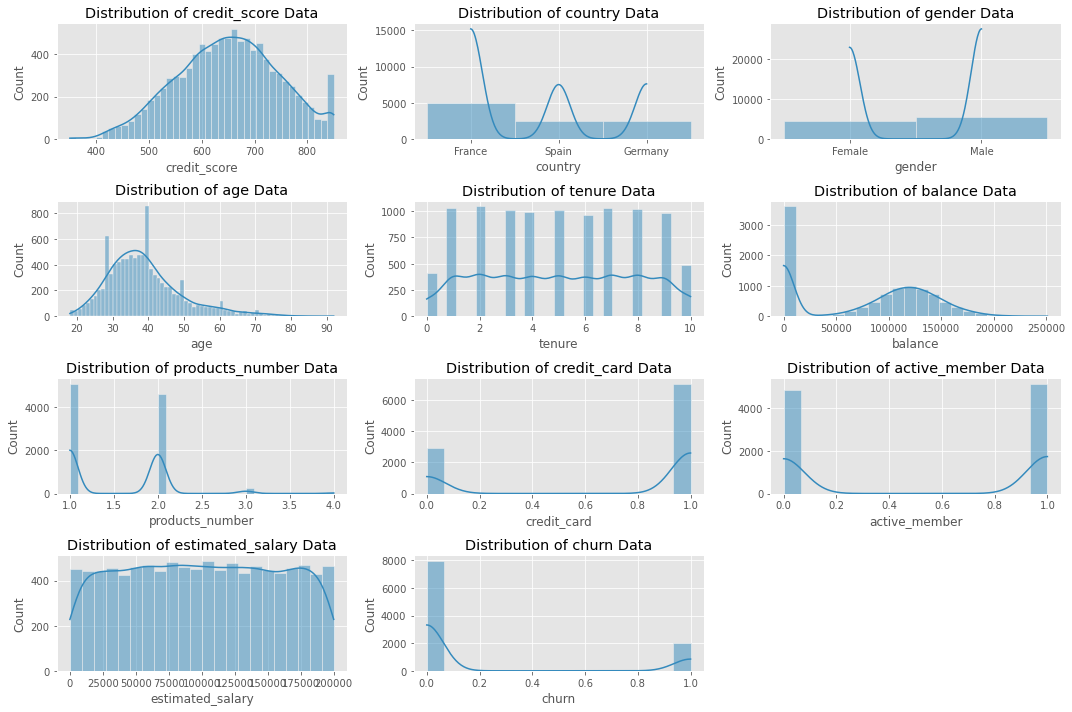

In [9]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(df.columns, 1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col], kde=True)
    plt.tight_layout()
    plt.plot()

Transforming Categorical Features into Numerical

In [10]:
dflazzy = df.copy()
choice_columns = ['country', 'gender']
for i in dflazzy[choice_columns]:
    dicio_encoder = LazzyLabelEncoder(df=dflazzy[i], text=False)
    dflazzy[str(i) + '_encoder'] = dflazzy[i].apply(lambda x: dicio_encoder.get(x))


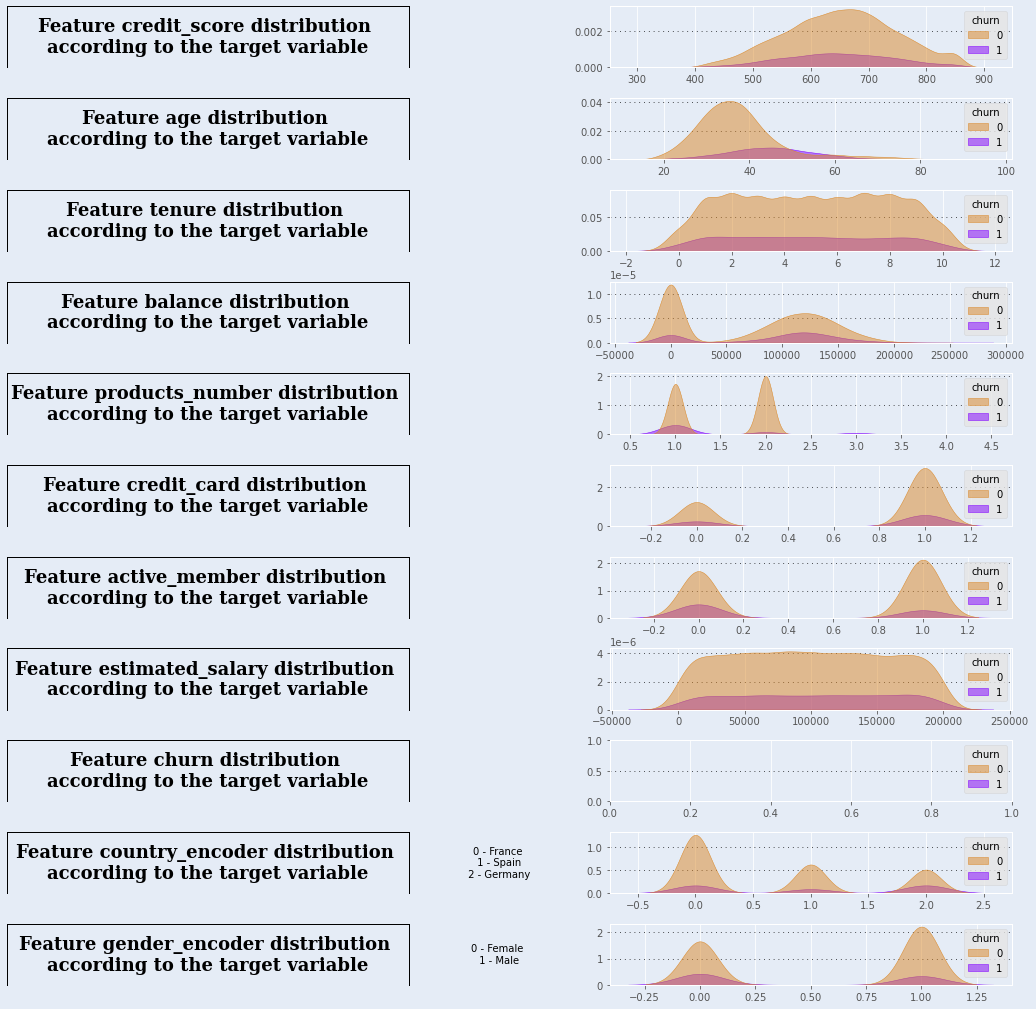

In [11]:
count_columns = dflazzy.select_dtypes(include= np.number).shape[1]

fig = plt.figure(figsize=(18,18))
gs = fig.add_gridspec(count_columns, 2)
gs.update(wspace=0.5, hspace=0.5)

background_color = "#E5ECF6"

for i, j in enumerate(dflazzy.select_dtypes(include= np.number)):
    
    legends = ''
    legends = LazzyLabelEncoder(df=dflazzy[j[:-8] if '_encoder' in j else j], text=True) if '_encoder' in j else ''

    globals()['axe' + str(i)] = fig.add_subplot(gs[i, 0])
    globals()['axe' + str(i+1)] = fig.add_subplot(gs[i, 1])

    fig.patch.set_facecolor(background_color) 
    globals()['axe' + str(i)].set_facecolor(background_color) 
    globals()['axe' + str(i+1)].set_facecolor(background_color) 

    globals()['axe' + str(i)].text(0.5, 0.5, f"Feature {j} distribution \naccording to the target variable",
        horizontalalignment = 'center', verticalalignment = 'center',
        fontsize = 18, fontweight='bold', fontfamily='serif',
        color='#000000')

    globals()['axe' + str(i)].grid(False)
    globals()['axe' + str(i)].spines["bottom"].set_visible(False)
    globals()['axe' + str(i)].spines[['left', 'top', 'right']].set_color('#000000')
    globals()['axe' + str(i)].set_xticklabels([])
    globals()['axe' + str(i)].set_yticklabels([])
    globals()['axe' + str(i)].tick_params(left=False, bottom=False)
    globals()['axe' + str(i)].text(1.22, 0.5, legends,
        horizontalalignment = 'center', verticalalignment = 'center', fontsize = 10
        )

    globals()['axe' + str(i+1)].grid(color='#000000', axis='y', zorder=0,  dashes=(1,5))
    sns.kdeplot(ax=globals()['axe' + str(i+1)], data=dflazzy, x=j, hue="churn", fill=True, palette=["#da8829", "#8000ff"], alpha=.5)
    globals()['axe' + str(i+1)].set_xlabel("")
    globals()['axe' + str(i+1)].set_ylabel("")


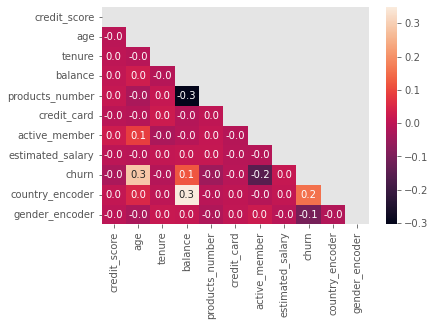

In [12]:
correlation = dflazzy.corr().transpose()
mask = np.triu(np.ones_like(correlation))
sns.heatmap(correlation,mask=mask,fmt=".1f",annot=True)
plt.show()

## Exploratory Data Analysis - SweetViz

In [13]:
my_report = sv.analyze(df_sv)
my_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Data Preparation

## Select Data

In [14]:
# Criando nova variável com base na estimated_salary
df['estimated_salary_month'] = df['estimated_salary'] / 12
df = df[['credit_score', 'country', 'gender', 'age', 'tenure', 'balance',
       'products_number', 'credit_card', 'active_member', 'estimated_salary', 'estimated_salary_month',
       'churn']]

In [15]:
# Aplicando a função LabelEncoder para transformar as colunas gender e country.
df['gender'] = func_LabelEncoder(df['gender'])
df['country'] = func_LabelEncoder(df['country'])

### Random Forest Model

#### Seleção de features

Para seleção de features do modelo de Random Forest iremos utilizar o ExtraTreesClassifier. 

In [16]:
X = df.drop(columns='churn')
y = df['churn']
Tree_feature = ExtraTreesClassifier()
Tree_feature.fit(X,y)
print(df.columns[0:11])
print(Tree_feature.feature_importances_)

Index(['credit_score', 'country', 'gender', 'age', 'tenure', 'balance',
       'products_number', 'credit_card', 'active_member', 'estimated_salary',
       'estimated_salary_month'],
      dtype='object')
[0.10969532 0.04286931 0.01700334 0.21987414 0.09155545 0.11249522
 0.14090659 0.02275958 0.03223205 0.10560593 0.10500308]


In [17]:
feature_importance = pd.DataFrame(Tree_feature.feature_importances_,
                                  index= df.columns[0:11],
                                  columns= ['importance']).sort_values('importance', ascending = False)

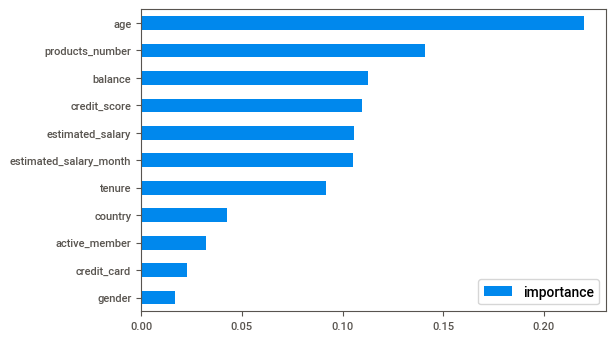

In [18]:
feature_importance.sort_values('importance').plot(kind='barh');

Como podemos ver acima as duas últimas colunas (Credit_card e gender) não estão sendo muito importantes para o modelo e devido a isso iremos retira-las do modelo de random forest.

In [19]:
X.drop(["gender", "credit_card"], axis=1, inplace=True)

#### Tuning Hiperparametros (Random Search)

In [20]:
X_treino, X_valid, y_treino, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

In [21]:
def treinar_modelo(params):
        max_depth = params[0]
        min_samples_split = params[1]
        n_jobs = params[2]
        max_samples = params[3]

        print(params, '\n')
            

        mdl = RandomForestClassifier(max_depth=max_depth, min_samples_split=min_samples_split,
                                     n_jobs=n_jobs, 
                                     max_samples=max_samples, n_estimators=500, random_state=42)

        mdl.fit(X_treino, y_treino)

        p_rs = mdl.predict_proba(X_valid)[:, 1]

        return -roc_auc_score(y_valid, p_rs)


space = [(4, 18), # max_depth
         (2, 10), # min_samples_split
         (1, 20), # n_jobs
         (0.3, 0.95)] # max_samples
resultado = dummy_minimize(treinar_modelo, space, n_calls=30, random_state=42, verbose = 1)

Iteration No: 1 started. Evaluating function at random point.
[7, 9, 7, 0.5897912893548343] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.6075
Function value obtained: -0.8688
Current minimum: -0.8688
Iteration No: 2 started. Evaluating function at random point.
[10, 9, 4, 0.3928634316492615] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.5591
Function value obtained: -0.8707
Current minimum: -0.8707
Iteration No: 3 started. Evaluating function at random point.
[6, 7, 2, 0.7692992019734362] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.0754
Function value obtained: -0.8672
Current minimum: -0.8707
Iteration No: 4 started. Evaluating function at random point.
[17, 7, 2, 0.4181862286846154] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.3308
Function value obtained: -0.8708
Current minimum: -0.8708
Iteration No: 5 started. Evaluating function at random point.
[8, 2, 12, 0.697574554317382

#### Cross Validation

In [22]:
result = []
for repet in range(15):
    print('Repetição: ', repet)
    kf1 = KFold(3, shuffle=True, random_state=repet)

    for linhas_treino, linhas_valid in kf1.split(X, groups=None):
        print("Treino", linhas_treino.shape[0]) 
        print("Valid", linhas_valid.shape[0])
       

        X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
        y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

        modelo_b = RandomForestClassifier(max_depth = resultado.x[0],
                                          min_samples_split = resultado.x[1],
                                          n_jobs = resultado.x[2],
                                          max_samples = resultado.x[3],
                                          n_estimators=500, random_state=repet)
        print('Repetição:',repet)
        modelo_b.fit(X_treino, y_treino)

        p = modelo_b.predict(X_valid)
        result.append(roc_auc_score(y_valid, p))
        acc1 = np.mean(p == y_valid)
        result.append(acc1)
        print('Acurácia:', acc1)
        print()

Repetição:  0
Treino 6666
Valid 3334
Repetição: 0
Acurácia: 0.8665266946610678

Treino 6667
Valid 3333
Repetição: 0
Acurácia: 0.8616861686168616

Treino 6667
Valid 3333
Repetição: 0
Acurácia: 0.8541854185418541

Repetição:  1
Treino 6666
Valid 3334
Repetição: 1
Acurácia: 0.8623275344931014

Treino 6667
Valid 3333
Repetição: 1
Acurácia: 0.8535853585358536

Treino 6667
Valid 3333
Repetição: 1
Acurácia: 0.8631863186318632

Repetição:  2
Treino 6666
Valid 3334
Repetição: 2
Acurácia: 0.8620275944811038

Treino 6667
Valid 3333
Repetição: 2
Acurácia: 0.8616861686168616

Treino 6667
Valid 3333
Repetição: 2
Acurácia: 0.8667866786678667

Repetição:  3
Treino 6666
Valid 3334
Repetição: 3
Acurácia: 0.8593281343731254

Treino 6667
Valid 3333
Repetição: 3
Acurácia: 0.8625862586258626

Treino 6667
Valid 3333
Repetição: 3
Acurácia: 0.8634863486348635

Repetição:  4
Treino 6666
Valid 3334
Repetição: 4
Acurácia: 0.8674265146970606

Treino 6667
Valid 3333
Repetição: 4
Acurácia: 0.8646864686468647

Treino

In [23]:
np.mean(result)

0.7817338327107753

#### Verificando a curva ROC

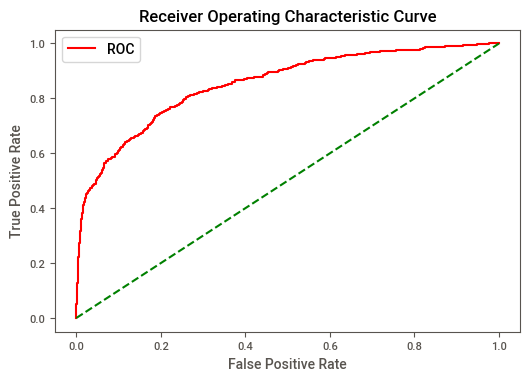

In [24]:
prob = modelo_b.predict_proba(X_valid)
prob = prob[:, 1]
fper, tper, thresholds = roc_curve(y_valid, prob)
plot_roc_curve(fper, tper)

### Logistic Regression Model

#### Seleção de Features

Para seleção de features do modelo de regressão logistica iremos utilizar o SelectKBest do ScikitLearn utilizando como métrica o chi2 e iremos selecionar as 9 variáveis mais importantes para o modelo.

In [25]:
X_lr = df.drop(columns='churn')
y_lr = df['churn']

In [26]:
KBest = SelectKBest(chi2, k=9)
fit = KBest.fit(X_lr, y_lr)
cols = fit.get_support(indices=True)
fit.transform(X_lr)
X_lr = X_lr.iloc[:,cols]

In [27]:
X_lr_treino, X_lr_valid, y_lr_treino, y_lr_valid = train_test_split(X_lr, y_lr, test_size=0.3, random_state=0)

#### Tuning Hiperparametros (Random Search)

In [28]:
def treinar_modelo(params):
        penalty = params[0]
        n_jobs = params[1]
        fit_intercept = params[2]
        max_iter = params[3]

        print(params, '\n')
            

        mdl_lg = LogisticRegression(penalty=penalty, n_jobs=n_jobs,
                                    fit_intercept=fit_intercept, 
                                    max_iter=max_iter, random_state=42)

        mdl_lg.fit(X_treino, y_treino)

        p = mdl_lg.predict_proba(X_valid)[:, 1]

        return -roc_auc_score(y_valid, p)


space = [('l2', 'none'), # penalty
         (1, 10), # n_jobs
         (True, False), # fit_intercept
         (100, 1000)] # max_iter
resultado_lg = dummy_minimize(treinar_modelo, space, n_calls=30, random_state=42, verbose = 1)

Iteration No: 1 started. Evaluating function at random point.
['none', 8, False, 714] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.8945
Function value obtained: -0.6632
Current minimum: -0.6632
Iteration No: 2 started. Evaluating function at random point.
['l2', 7, True, 187] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.7331
Function value obtained: -0.6632
Current minimum: -0.6632
Iteration No: 3 started. Evaluating function at random point.
['l2', 8, False, 761] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.6681
Function value obtained: -0.6632
Current minimum: -0.6632
Iteration No: 4 started. Evaluating function at random point.
['l2', 8, False, 905] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.6662
Function value obtained: -0.6632
Current minimum: -0.6632
Iteration No: 5 started. Evaluating function at random point.
['l2', 5, False, 413] 

Iteration No: 5 ended. Evaluation don

#### Cross Validation

In [29]:
result_lg = []
for repet in range(15):
    print('Repetição: ', repet)
    kf1 = KFold(3, shuffle=True, random_state=repet)

    for linhas_treino, linhas_valid in kf1.split(X):
        print("Treino", linhas_treino.shape[0]) 
        print("Valid", linhas_valid.shape[0])
       

        X_lr_treino, X_lr_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
        y_lr_treino, y_lr_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

        modelo_lg = LogisticRegression(penalty=resultado_lg.x[0], n_jobs=resultado_lg.x[1],
                                       fit_intercept=resultado_lg.x[2], 
                                       max_iter=resultado_lg.x[3], random_state=repet)
        print('Repetição:',repet)
        modelo_lg.fit(X_lr_treino, y_lr_treino)

        p = modelo_lg.predict(X_lr_valid)
        result_lg.append(roc_auc_score(y_lr_valid, p))
        acc1 = np.mean(p == y_lr_valid)
        result_lg.append(acc1)
        print('Acurácia:', acc1)
        print()

Repetição:  0
Treino 6666
Valid 3334
Repetição: 0
Acurácia: 0.7819436112777445

Treino 6667
Valid 3333
Repetição: 0
Acurácia: 0.8007800780078008

Treino 6667
Valid 3333
Repetição: 0
Acurácia: 0.7878787878787878

Repetição:  1
Treino 6666
Valid 3334
Repetição: 1
Acurácia: 0.7873425314937013

Treino 6667
Valid 3333
Repetição: 1
Acurácia: 0.7902790279027903

Treino 6667
Valid 3333
Repetição: 1
Acurácia: 0.7926792679267927

Repetição:  2
Treino 6666
Valid 3334
Repetição: 2
Acurácia: 0.788242351529694

Treino 6667
Valid 3333
Repetição: 2
Acurácia: 0.7857785778577858

Treino 6667
Valid 3333
Repetição: 2
Acurácia: 0.7974797479747975

Repetição:  3
Treino 6666
Valid 3334
Repetição: 3
Acurácia: 0.7864427114577085

Treino 6667
Valid 3333
Repetição: 3
Acurácia: 0.7893789378937894

Treino 6667
Valid 3333
Repetição: 3
Acurácia: 0.7947794779477948

Repetição:  4
Treino 6666
Valid 3334
Repetição: 4
Acurácia: 0.795740851829634

Treino 6667
Valid 3333
Repetição: 4
Acurácia: 0.7941794179417941

Treino 6

In [30]:
np.mean(result_lg)

0.6531108332525549

#### Verificando a curva ROC

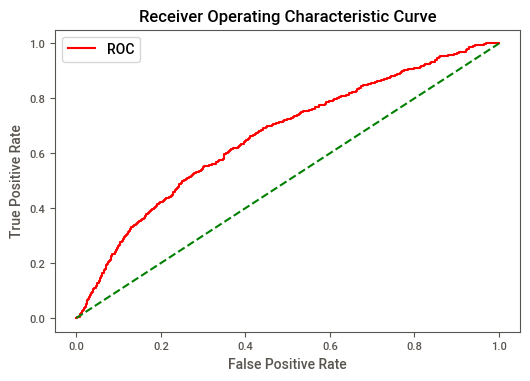

In [31]:
prob_lg = modelo_lg.predict_proba(X_lr_valid)
prob_lg = prob_lg[:, 1]
fper, tper, thresholds = roc_curve(y_lr_valid, prob_lg)
plot_roc_curve(fper, tper)

### Gradient Boosting Classifier Model

Utilizaremos a mesma feature select do modelo de LogisticRegression e consequentemente o mesmo split de treino e teste para seleção dos hiperparametros 

In [35]:
def treinar_modelo(params):
        loss = params[0]
        learning_rate = params[1]
        max_depth = params[2]
        subsample = params[3]

        print(params, '\n')
            

        mdl_XG = GradientBoostingClassifier(loss=loss, learning_rate=learning_rate,
                                            max_depth=max_depth, 
                                            subsample=subsample, n_estimators=500, random_state=42)

        mdl_XG.fit(X_treino, y_treino)

        p = mdl_XG.predict_proba(X_valid)[:, 1]

        return -roc_auc_score(y_valid, p)


space = [('log_loss', 'exponential'), # loss
         (0.01, 0.2), # learning_rate
         (2, 18), # max_depth
         (0.1, 1.0)] # subsample
resultado_XG = dummy_minimize(treinar_modelo, space, n_calls=30, random_state=42, verbose = 1)

Iteration No: 1 started. Evaluating function at random point.
['exponential', 0.04485261007457113, 9, 0.638792635777333] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 16.1182
Function value obtained: -0.8441
Current minimum: -0.8441
Iteration No: 2 started. Evaluating function at random point.
['log_loss', 0.039638958863878505, 12, 0.5133240027692805] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 25.7352
Function value obtained: -0.8473
Current minimum: -0.8473
Iteration No: 3 started. Evaluating function at random point.
['log_loss', 0.03714469540516875, 4, 0.1185260448662222] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.2765
Function value obtained: -0.8449
Current minimum: -0.8473
Iteration No: 4 started. Evaluating function at random point.
['exponential', 0.16816410175208016, 7, 0.1007008892569129] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.5447
Function value obtained: -0.8038


In [36]:
result_XG = []
for repet in range(15):
    print('Repetição: ', repet)
    kf1 = KFold(3, shuffle=True, random_state=repet)

    for linhas_treino, linhas_valid in kf1.split(X):
        print("Treino", linhas_treino.shape[0]) 
        print("Valid", linhas_valid.shape[0])
       

        X_lr_treino, X_lr_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
        y_lr_treino, y_lr_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

        modelo_XG = GradientBoostingClassifier(loss=resultado_XG.x[0], learning_rate=resultado_XG.x[1],
                                       max_depth=resultado_XG.x[2], 
                                       subsample=resultado_XG.x[3], random_state=repet)
        print('Repetição:',repet)
        modelo_XG.fit(X_lr_treino, y_lr_treino)

        p = modelo_XG.predict(X_lr_valid)
        result_lg.append(roc_auc_score(y_lr_valid, p))
        acc1 = np.mean(p == y_lr_valid)
        result_XG.append(acc1)
        print('Acurácia:', acc1)
        print()

Repetição:  0
Treino 6666
Valid 3334
Repetição: 0
Acurácia: 0.8650269946010798

Treino 6667
Valid 3333
Repetição: 0
Acurácia: 0.8640864086408641

Treino 6667
Valid 3333
Repetição: 0
Acurácia: 0.8544854485448545

Repetição:  1
Treino 6666
Valid 3334
Repetição: 1
Acurácia: 0.8620275944811038

Treino 6667
Valid 3333
Repetição: 1
Acurácia: 0.8556855685568557

Treino 6667
Valid 3333
Repetição: 1
Acurácia: 0.8601860186018602

Repetição:  2
Treino 6666
Valid 3334
Repetição: 2
Acurácia: 0.8623275344931014

Treino 6667
Valid 3333
Repetição: 2
Acurácia: 0.8604860486048604

Treino 6667
Valid 3333
Repetição: 2
Acurácia: 0.8658865886588659

Repetição:  3
Treino 6666
Valid 3334
Repetição: 3
Acurácia: 0.8578284343131374

Treino 6667
Valid 3333
Repetição: 3
Acurácia: 0.8601860186018602

Treino 6667
Valid 3333
Repetição: 3
Acurácia: 0.8631863186318632

Repetição:  4
Treino 6666
Valid 3334
Repetição: 4
Acurácia: 0.8671265746850629

Treino 6667
Valid 3333
Repetição: 4
Acurácia: 0.8613861386138614

Treino

In [37]:
np.mean(result_XG)

0.8604066465434786

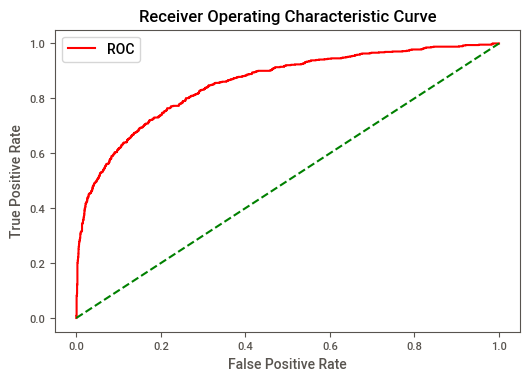

In [38]:
prob_lg = modelo_XG.predict_proba(X_lr_valid)
prob_lg = prob_lg[:, 1]
fper, tper, thresholds = roc_curve(y_lr_valid, prob_lg)
plot_roc_curve(fper, tper)

## Clean Data

## Construct Data

## Integrate Data

## Format Data

# Modeling

## Select Modeling Techniques

## Generate Test Design

## Build Model

## Assess Model

# Evaluation

## Evaluate Results

## Review Process

## Determine Next Steps

# Deployment

## Plan Deployment

## Plan Monitoring and Maintenance

## Produce Final Report

## Produce Final Report

## Review Project